In [48]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
!sudo -H pip install scikit-learn

In [49]:
import os
import datetime
import pandas as pd
import matplotlib.dates as mdates
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
#from statsmodels.graphics import tsaplots
import sys; sys.version

'3.6.9 (default, Oct  8 2020, 12:12:24) \n[GCC 8.4.0]'

In [50]:
#HEDGE FUNDS

hedgefund_df = pd.read_csv('hedge-fund-NAVROR-daily.csv', skiprows = 2)

hedgefund_df['Date'] = pd.to_datetime(hedgefund_df.Date)

#SP500

sp_df = pd.read_csv('S&P 500 OHCL Data.csv').iloc[::-1]
sp_df.Date = pd.to_datetime(sp_df.Date, infer_datetime_format = True)
mask = sp_df.Date > pd.Timestamp(datetime.date(year = 2001, month = 6, day = 8))
sp_df = sp_df.loc[mask]

#BANKS AND INSURANCES

csv_paths = ['banks.csv', 'brokers.csv', 'insurers.csv']

def process_csv_path(csv_path):
    h_df = pd.read_csv(csv_path)
    h_df['Date'] = pd.to_datetime(h_df.Date, infer_datetime_format = True)
    mask = h_df.Date > pd.Timestamp(datetime.date(year = 2001, month = 6, day = 8))
    h_df = h_df.loc[mask]
    return(h_df)

dfs = [process_csv_path(csv_path).reset_index() for csv_path in csv_paths]

bank_df = dfs[0]
brok_df = dfs[1]
ins_df = dfs[2]

#print(bank_df)

In [51]:
hedgefund_df.head()

,Date,CCY,NAV,ROR,CCY.1,NAV.1,ROR.1,CCY.2,NAV.2,ROR.2,CCY.3,NAV.3,ROR.3,CCY.4,NAV.4,ROR.4,CCY.5,NAV.5,ROR.5
0,2020-06-08,USD,1405.94,0.22%,USD,1639.25,-0.01%,USD,1145.41,-0.02%,USD,1764.73,0.89%,USD,988.28,0.10%,USD,1240.18,0.05%
1,2020-06-07,USD,1402.83,0.00%,USD,1639.40,0.00%,USD,1145.59,0.00%,USD,1749.20,0.00%,USD,987.34,0.00%,USD,1239.56,0.00%
2,2020-06-06,USD,1402.83,0.00%,USD,1639.40,0.00%,USD,1145.59,0.00%,USD,1749.20,0.00%,USD,987.34,0.00%,USD,1239.56,0.00%
3,2020-06-05,USD,1402.83,0.71%,USD,1639.40,0.95%,USD,1145.59,0.35%,USD,1749.20,1.39%,USD,987.34,-0.66%,USD,1239.56,0.15%
4,2020-06-04,USD,1392.99,0.02%,USD,1623.98,0.14%,USD,1141.61,0.06%,USD,1725.17,-0.14%,USD,993.89,-0.05%,USD,1237.70,0.29%


Debugging `filter_for_common_dates`

In [52]:
dfs = [hedgefund_df, sp_df, bank_df, brok_df, ins_df]

In [53]:
from functools import reduce

common_dates = sorted(reduce(lambda x, y: set(x).intersection(set(y)), [df.Date for df in dfs]))

df_maps = []
for df in dfs:
    df_map = {}
    for i, row in df.iterrows():
        assert i == row.name
        df_map[row.Date] = row.name
    df_maps.append(df_map)

In [54]:
df_return = []
for i, df in enumerate(dfs):
    df_map = df_maps[i]
    mask = []
    for date in common_dates:
        mask.append(df_map[date])
    mask = np.array(mask)
    print(min(mask), max(mask), len(df))
    # df_return.append(df.iloc[mask])

68 5241 8196
46 3610 3630
48 198 199
48 198 199
48 198 199


In [55]:
# Function to filter dates 

def filter_for_common_dates(dfs):
    
    from functools import reduce

    
    common_dates = sorted(reduce(lambda x, y: set(x).intersection(set(y)), [df.Date for df in dfs]))
    
    df_maps = []
    for df in dfs:
        df_map = {}
        for i, row in df.iterrows():
            df_map[row.Date] = row.name
        df_maps.append(df_map)

    
    df_return = []
    for i, df in enumerate(dfs):
        df_map = df_maps[i]
        mask = []
        for date in common_dates:
            mask.append(df_map[date])
        ask = np.array(mask)
        df_return.append(df.iloc[mask])
    
    return [df.reset_index(drop=True) for df in df_return]

hedgefund_df, sp_df, bank_df, brok_df, ins_df = filter_for_common_dates([hedgefund_df, sp_df, bank_df, brok_df, ins_df])

In [56]:
hf_df = hedgefund_df

In [57]:
lab_open = (hf_df['NAV'])

sp_open = sp_df['Open']

bank_open = bank_df['val']
brok_open = brok_df['val']
ins_open = ins_df['val'] 

def returns(a, b):
    return ((float(a) - float(b)) / (float(b) - 1))


def create_initial_array(return_period):

    lab_ret = []
    bank_ret = []
    brok_ret = []
    ins_ret = []

    for i in range (0, len(hf_df) - return_period, return_period):

        #HEDGE FUNDS
        lab_ret.append(returns(lab_open[i + return_period], lab_open[i]))


        #BANKS
        bank_ret.append(returns(bank_open[i + return_period], bank_open[i]))

        #BROKERAGES
        brok_ret.append(returns(brok_open[i + return_period], brok_open[i]))

        #INSURERS
        ins_ret.append(returns(ins_open[i + return_period], ins_open[i]))

    
    initial_array = np.array([[lab_ret], [bank_ret], [brok_ret], [ins_ret]])
    initial_array = np.reshape(initial_array, ((initial_array.shape[0] * initial_array.shape[1]), initial_array.shape[2]))
    return(initial_array)

return_period = 1
initial_array = create_initial_array(return_period)
print(initial_array.shape)


(4, 150)


In [58]:
def pca_calculationss(subdivided_array):    
    r_assets, r_time_periods = subdivided_array.shape

    delta = subdivided_array - np.expand_dims(np.mean(subdivided_array, axis = 1), axis = 1)
    sigma = delta @ delta.T / (r_time_periods - r_assets)

    ret_mean = np.mean(subdivided_array, axis=1)

    delta = np.zeros_like(sigma)
    for m in range(r_time_periods):
        ret = np.array(subdivided_array[:, m]) - ret_mean
        delta += np.outer(ret, ret)
    delta /= r_time_periods - r_assets
    sigma_new = np.copy(delta)
    np.allclose(sigma, sigma_new)
    evals, evecs = np.linalg.eigh(sigma)
    num= list((np.cumsum(evals / np.sum(evals))))
    return(num[0])

In [59]:
def pca_calculations(subdivided_array):    
    r_assets, r_time_periods= subdivided_array.shape

    delta = subdivided_array - np.expand_dims(np.mean(subdivided_array, axis=1), axis=1)
    sigma = delta @ delta.T / (r_time_periods - r_assets)

    ret_mean = np.mean(subdivided_array, axis=1)

    delta = np.zeros_like(sigma)
    for m in range(r_time_periods):
        ret = np.array(subdivided_array[:, m]) - ret_mean
        delta += np.outer(ret, ret)
    delta /= r_time_periods - r_assets
    sigma_new = np.copy(delta)
    np.allclose(sigma, sigma_new)
    evals, evecs = np.linalg.eigh(sigma)
    evals = evals[::-1]
    evecs = evecs[:, ::-1]
    return evals[0] / sum(evals)


In [60]:
sp_df

,Date,Price,Open,High,Low,Vol.,Change %
0,2020-05-11,"2,930.32","2,915.46","2,944.25","2,903.44",-,0.02%
1,2020-04-14,"2,846.06","2,805.10","2,851.85","2,805.10",-,3.06%
2,2020-03-11,"2,741.38","2,825.60","2,825.60","2,707.22",-,-4.89%
3,2020-02-12,"3,379.45","3,370.50","3,381.47","3,369.72",-,0.65%
4,2020-01-10,"3,265.35","3,281.81","3,282.99","3,260.86",-,-0.29%
...,...,...,...,...,...,...,...
146,2006-08-08,"1,271.48","1,275.67","1,282.75","1,268.37",-,-0.34%
147,2006-07-11,"1,272.43","1,267.26","1,273.64","1,259.65",-,0.40%
148,2006-05-10,"1,322.85","1,324.57","1,325.51","1,317.44",-,-0.17%
149,2006-04-12,"1,288.12","1,286.57","1,290.93","1,286.45",-,0.12%


In [61]:
initial_array.shape
print(initial_array)

[[ 4.98759431e-03  1.43720872e-02  1.60186760e-02 -8.88524951e-03
   1.23313685e-04  3.23042020e-03  2.32775361e-02  1.03891424e-02
   2.13967311e-02  1.94704684e-02  3.50692938e-02  3.27561487e-03
   2.43604824e-02  2.13772898e-02  1.45206199e-02  2.16452458e-03
  -1.46642416e-02  4.50355019e-02  2.05437521e-02 -1.68653135e-02
  -2.95679834e-02  1.53684406e-02  5.26860763e-03  1.56623951e-02
   1.48541431e-02 -1.35394623e-02 -5.53183037e-03 -7.86553883e-02
  -6.59028583e-02 -7.83271639e-03  3.95663259e-02 -1.52444169e-02
   3.57020450e-02  1.05344438e-02  2.44951425e-02  1.07507405e-02
   2.27591369e-02  6.18416442e-05  1.56655811e-02  1.82652109e-04
   8.99904632e-03  6.54580556e-03  8.38128347e-03  1.08576127e-02
   1.06331893e-02 -3.46573058e-02  1.34605726e-03  3.81806509e-02
  -1.14310561e-02  3.12393091e-02  9.75327716e-03 -4.79668081e-03
   2.24578150e-02  5.04603236e-03  6.44338177e-03  1.70267485e-02
   1.61588264e-02 -1.56989058e-02  8.25705346e-03 -1.73925415e-02
  -3.48487

In [62]:
n_assets, n_time_periods = initial_array.shape
n_sub = 30

In [65]:
pca_vals = []
for i in range(n_time_periods - n_sub):
    sub_array = initial_array[:, i:i + n_sub]
    pca_vals.append(pca_calculations(sub_array))
    
print(len(pca_vals))
    
dates = []
date_list = list(sp_df['Date'])
for n in range(0, n_time_periods - n_sub):
    dates.append(date_list[n])
    
print(len(dates))

120
120


Text(0.5, 0, 'Time (Years)')

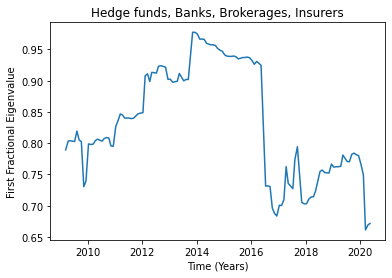

In [69]:
plt.plot(dates, pca_vals)
plt.title("Hedge funds, Banks, Brokerages, Insurers")
plt.ylabel("First Fractional Eigenvalue")
plt.xlabel("Time (Years)")

In [31]:
# Subdivision code to divide the initial array of all data points into smaller arrays of n_assets*period_length, where period can be user inputed. Each array created per period will have the pca_calculation function applied on it to return the fractional variance of the 1st two eigenvalues. The function will append this value to an empty to list that will at the end, contain the eigenvalues of all periods, a seperate list will be created with corresponding period numbers (period 1, period 2, etc.). The function will return both lists (eigenvalues, period) which will be plotted later.

def time_duration_autocorrelation(return_length, period, scarray):

    # Initializing lists that will be returned in function
    period_list = []
    eigen_list = []

    # Creating initial lists for each assets daily returns over each period, these will be the rows for each array created
    lab = []
    bank = []
    brok = []
    ins = []

    # return list that data will be appended to in the loop for each asset
    return_list = []

    # Variables needed to keep track of certain counts and loops, count is to help check if period has ended, i is for the return data range, and periods tracks        what period the code is running at
    period_len = int(period / return_length)
    count = 0
    periods = 0
    i = 0

    #Creating ranges for the loops
    n_assets, n_time_periods = scarray.shape

    #While loop over whole time period to keep the subdivision running over all periods
    while i<= n_time_periods:
        # If statement check to reset the array after each period has ended
        if count%period == 0:
            subdivided_array = np.array([[]])
        # Below loops create the data array for each period that is length n_assets*period_length
        for t in range((n_assets)):
            for c in range(i, period_len+i):
                if c < n_time_periods:
                    return_list.append(scarray[t,c])
            if t==0:
                lab = return_list
            if t==1:
                bank = return_list
            if t==2:
                brok = return_list
            if t==3:
                ins = return_list

                #Creating array using seperate return lists created for each asset
                period_array = np.array([[lab], [bank], [brok], [ins]])
                period_array = np.reshape(period_array, ((period_array.shape[0]*period_array.shape[1]), period_array.shape[2]))

                #Creating datapoints to append to list of eigenvalues and periods
                val = float(pca_calculations(period_array))
                eigen_list.append(val)
                period_list.append(periods)
                periods += 1
                
#                 if val <= 0.6:
#                     import ipdb; ipdb.set_trace()
#                     assert False


            return_list = []
        i = period_len + i
        count += 1
    return(eigen_list, period_list)

In [32]:
initial_array.shape

(4, 150)

In [33]:
x = np.linspace(2006, 2020, len(period))

NameError: name 'period' is not defined

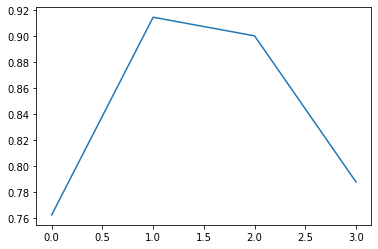

In [34]:
#Plotting fractional eigenvalues per period periods go from 2006-2020

frac_evals, period= time_duration_autocorrelation(return_period, 40, initial_array)

plt.figure()
plt.plot(period, frac_evals)